In [1]:
import os
import pydicom
import SimpleITK as sitk
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- Config ---
DICOM_ROOT = r"C:\Users\anude\Downloads\project"
KTRANS_DIR = r"C:\Users\anude\Downloads\ProstateXKtrains-train-fixed"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
OUTPUT_DIR = r"C:\Users\anude\Downloads\processed_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

findings_df = pd.read_csv(FINDINGS_CSV)
findings_df['ProxID'] = findings_df['ProxID'].astype(str)

# Keywords for modality matching
modality_keywords = {
    "T2": ["t2", "t2w"],
    "ADC": ["adc"],
    "DWI": ["dwi", "diffusion", "ep2d_diff", "ep2d"]
}

# --- Functions ---
def match_series_description(description, keywords):
    description = description.lower()
    return any(kw in description for kw in keywords)

def find_series_by_modality(patient_folder, keywords):
    for root, dirs, files in os.walk(patient_folder):
        dcm_files = [f for f in files if f.endswith('.dcm')]
        if not dcm_files:
            continue
        try:
            sample_dcm = pydicom.dcmread(os.path.join(root, dcm_files[0]), stop_before_pixels=True)
            if hasattr(sample_dcm, 'SeriesDescription'):
                if match_series_description(sample_dcm.SeriesDescription, keywords):
                    # Load full series as SimpleITK image
                    series_paths = [os.path.join(root, f) for f in dcm_files]
                    reader = sitk.ImageSeriesReader()
                    reader.SetFileNames(series_paths)
                    return reader.Execute()
        except Exception:
            continue
    return None

def load_ktrans_volume(ktrans_dir, proxid):
    for root, dirs, files in os.walk(ktrans_dir):
        for file in files:
            if file.endswith(".mhd") and proxid in file:
                return sitk.ReadImage(os.path.join(root, file))
    return None


def normalize(vol):
    arr = sitk.GetArrayFromImage(vol).astype(np.float32)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-5)

# --- Data Preprocessing ---
processed = 0
for proxid in tqdm(findings_df['ProxID'].unique()):
    patient_folder = os.path.join(DICOM_ROOT, proxid)
    if not os.path.isdir(patient_folder):
        print(f"[SKIP] Folder not found: ProstateX-{proxid}")
        continue

    try:
        t2 = find_series_by_modality(patient_folder, modality_keywords["T2"])
        adc = find_series_by_modality(patient_folder, modality_keywords["ADC"])
        ktrans = load_ktrans_volume(KTRANS_DIR, proxid)

        if None in [t2, adc, ktrans]:
            print(f"[WARN] Missing one or more modalities for {proxid}")
            continue

        # Resample adc and ktrans to match t2
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(t2)
        adc = resampler.Execute(adc)
        ktrans = resampler.Execute(ktrans)

        t2_arr = normalize(t2)
        adc_arr = normalize(adc)
        ktrans_arr = normalize(ktrans)

        stacked = np.stack([t2_arr, adc_arr, ktrans_arr], axis=0)  # [C, D, H, W]
        np.save(os.path.join(OUTPUT_DIR, f"{proxid}.npy"), stacked)
        processed += 1

    except Exception as e:
        print(f"[ERROR] {proxid}: {e}")

print(f"\n✅ Finished. Processed {processed} patient volumes.")


100%|██████████| 101/101 [01:32<00:00,  1.09it/s]


✅ Finished. Processed 101 patient volumes.


In [25]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

# === Config ===
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load labels and volume paths ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)

# Only use IDs that have .npy files
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]

# Split into train/val
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)
def resize_volume(vol, target_shape=(3, 64, 64, 64)):
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    
    # Crop if too big
    d = min(d, td)
    h = min(h, th)
    w = min(w, tw)

    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

def load_tensor_dataset(dataframe, target_shape=(3, 64, 64, 64)):
    x_list, y_list = [], []
    for _, row in dataframe.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            vol = resize_volume(vol, target_shape)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))  # [N, 3, 64, 64, 64]
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor)

train_data = load_tensor_dataset(train_df)
val_data = load_tensor_dataset(val_df)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# === Define model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Linear(32 * 16 * 16 * 16, 128),  # adjust if input shape is different
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(DEVICE)

# === Training ===
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.BCELoss()

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x_batch).squeeze()
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

# === Evaluation ===
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        preds = model(x_batch).squeeze().cpu().numpy()
        preds = (preds > 0.5).astype(int)
        all_preds += [int(preds)] if np.isscalar(preds) else preds.tolist()
        all_labels += [int(y_batch)] if torch.numel(y_batch) == 1 else y_batch.numpy().tolist()

print("\n📊 Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"]))


Epoch 1/10: 100%|██████████| 29/29 [00:00<00:00, 46.67it/s]


Epoch 1 - Loss: 15.1699


Epoch 2/10: 100%|██████████| 29/29 [00:00<00:00, 47.42it/s]


Epoch 2 - Loss: 14.4958


Epoch 3/10: 100%|██████████| 29/29 [00:00<00:00, 45.29it/s]


Epoch 3 - Loss: 14.1417


Epoch 4/10: 100%|██████████| 29/29 [00:00<00:00, 47.65it/s]


Epoch 4 - Loss: 13.2095


Epoch 5/10: 100%|██████████| 29/29 [00:00<00:00, 47.34it/s]


Epoch 5 - Loss: 13.4180


Epoch 6/10: 100%|██████████| 29/29 [00:00<00:00, 47.84it/s]


Epoch 6 - Loss: 12.5728


Epoch 7/10: 100%|██████████| 29/29 [00:00<00:00, 47.96it/s]


Epoch 7 - Loss: 12.2436


Epoch 8/10: 100%|██████████| 29/29 [00:00<00:00, 48.80it/s]


Epoch 8 - Loss: 11.8945


Epoch 9/10: 100%|██████████| 29/29 [00:00<00:00, 48.22it/s]


Epoch 9 - Loss: 10.9986


Epoch 10/10: 100%|██████████| 29/29 [00:00<00:00, 48.56it/s]


Epoch 10 - Loss: 10.9985

📊 Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.79      0.96      0.86        23
     ClinSig       0.00      0.00      0.00         6

    accuracy                           0.76        29
   macro avg       0.39      0.48      0.43        29
weighted avg       0.62      0.76      0.68        29



In [27]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm

# === Config ===
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE = 4
EPOCHS = 10
LR = 1e-4
TARGET_SHAPE = (3, 64, 64, 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load and Clean Labels ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)

# Fix double-prefix naming (if needed)
df['ProxID'] = df['ProxID'].apply(lambda x: x if x.startswith("ProstateX-") else f"ProstateX-{x}")
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]

# === Split ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)

# === Utility: Resize to target shape ===
def resize_volume(vol, target_shape):
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d = min(d, td)
    h = min(h, th)
    w = min(w, tw)
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

# === Utility: Load volumes ===
def load_tensor_dataset(dataframe, shape=TARGET_SHAPE):
    x_list, y_list = [], []
    for _, row in dataframe.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            vol = resize_volume(vol, shape)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor)

# === Load Datasets and Dataloaders ===
train_data = load_tensor_dataset(train_df)
val_data = load_tensor_dataset(val_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# === Define 3D CNN ===
model = nn.Sequential(
    nn.Conv3d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(16, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Linear(32 * 16 * 16 * 16, 128),
    nn.ReLU(),
    nn.Linear(128, 1)  # <- No sigmoid here!
).to(DEVICE)

# === Balanced Loss Function ===
pos_weight_val = len(train_df) / train_df['ClinSig'].sum()
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_val]).to(DEVICE))
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f"📊 Train Class Distribution:\n{train_df['ClinSig'].value_counts()}")
print(f"📊 Val Class Distribution:\n{val_df['ClinSig'].value_counts()}")
print(f"🧠 Using pos_weight={pos_weight_val:.2f}")

# === Training ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_batch).squeeze()
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")

# === Evaluation ===
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds += preds.tolist() if not np.isscalar(preds) else [int(preds)]
        all_labels += y_batch.numpy().tolist() if y_batch.ndim > 0 else [float(y_batch)]

# === Report ===
print("\n📊 Final Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"]))


📊 Train Class Distribution:
ClinSig
0    94
1    22
Name: count, dtype: int64
📊 Val Class Distribution:
ClinSig
0    23
1     6
Name: count, dtype: int64
🧠 Using pos_weight=5.27


Epoch 1/10: 100%|██████████| 29/29 [00:00<00:00, 43.71it/s]


Epoch 1 - Loss: 37.5389


Epoch 2/10: 100%|██████████| 29/29 [00:00<00:00, 46.90it/s]


Epoch 2 - Loss: 36.4940


Epoch 3/10: 100%|██████████| 29/29 [00:00<00:00, 46.88it/s]


Epoch 3 - Loss: 36.5147


Epoch 4/10: 100%|██████████| 29/29 [00:00<00:00, 46.30it/s]


Epoch 4 - Loss: 36.5655


Epoch 5/10: 100%|██████████| 29/29 [00:00<00:00, 47.82it/s]


Epoch 5 - Loss: 36.4950


Epoch 6/10: 100%|██████████| 29/29 [00:00<00:00, 47.93it/s]


Epoch 6 - Loss: 36.3846


Epoch 7/10: 100%|██████████| 29/29 [00:00<00:00, 46.97it/s]


Epoch 7 - Loss: 36.1832


Epoch 8/10: 100%|██████████| 29/29 [00:00<00:00, 47.11it/s]


Epoch 8 - Loss: 36.1991


Epoch 9/10: 100%|██████████| 29/29 [00:00<00:00, 46.95it/s]


Epoch 9 - Loss: 36.2701


Epoch 10/10: 100%|██████████| 29/29 [00:00<00:00, 47.89it/s]


Epoch 10 - Loss: 36.1233

📊 Final Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       1.00      0.04      0.08        23
     ClinSig       0.21      1.00      0.35         6

    accuracy                           0.24        29
   macro avg       0.61      0.52      0.22        29
weighted avg       0.84      0.24      0.14        29



📊 Train class distribution:
 ClinSig
0    94
1    44
Name: count, dtype: int64
📊 Val class distribution:
 ClinSig
0    23
1     6
Name: count, dtype: int64


Epoch 1/30: 100%|██████████| 35/35 [00:10<00:00,  3.23it/s]


Epoch 1 - Loss: 47.0493


Epoch 2/30: 100%|██████████| 35/35 [00:03<00:00, 11.04it/s]


Epoch 2 - Loss: 22.9375


Epoch 3/30: 100%|██████████| 35/35 [00:03<00:00, 11.27it/s]


Epoch 3 - Loss: 20.6285


Epoch 4/30: 100%|██████████| 35/35 [00:03<00:00, 11.39it/s]


Epoch 4 - Loss: 13.8662


Epoch 5/30: 100%|██████████| 35/35 [00:03<00:00, 11.24it/s]


Epoch 5 - Loss: 10.1938


Epoch 6/30: 100%|██████████| 35/35 [00:03<00:00, 11.33it/s]


Epoch 6 - Loss: 10.3677


Epoch 7/30: 100%|██████████| 35/35 [00:03<00:00, 11.38it/s]


Epoch 7 - Loss: 3.0000


Epoch 8/30: 100%|██████████| 35/35 [00:03<00:00, 10.89it/s]


Epoch 8 - Loss: 4.1359


Epoch 9/30: 100%|██████████| 35/35 [00:03<00:00, 11.09it/s]


Epoch 9 - Loss: 5.2895


Epoch 10/30: 100%|██████████| 35/35 [00:03<00:00, 11.12it/s]


Epoch 10 - Loss: 3.3963


Epoch 11/30: 100%|██████████| 35/35 [00:03<00:00, 11.08it/s]


Epoch 11 - Loss: 1.8101


Epoch 12/30: 100%|██████████| 35/35 [00:03<00:00, 11.10it/s]


Epoch 12 - Loss: 0.6904


Epoch 13/30: 100%|██████████| 35/35 [00:03<00:00, 10.85it/s]


Epoch 13 - Loss: 1.4547


Epoch 14/30: 100%|██████████| 35/35 [00:03<00:00, 11.20it/s]


Epoch 14 - Loss: 0.9169


Epoch 15/30: 100%|██████████| 35/35 [00:03<00:00, 11.26it/s]


Epoch 15 - Loss: 1.4194


Epoch 16/30: 100%|██████████| 35/35 [00:03<00:00, 11.42it/s]


Epoch 16 - Loss: 0.7510


Epoch 17/30: 100%|██████████| 35/35 [00:03<00:00, 11.46it/s]


Epoch 17 - Loss: 1.0909


Epoch 18/30: 100%|██████████| 35/35 [00:03<00:00, 11.26it/s]


Epoch 18 - Loss: 0.4858


Epoch 19/30: 100%|██████████| 35/35 [00:03<00:00, 11.23it/s]


Epoch 19 - Loss: 0.1918


Epoch 20/30: 100%|██████████| 35/35 [00:03<00:00, 11.34it/s]


Epoch 20 - Loss: 0.2493


Epoch 21/30: 100%|██████████| 35/35 [00:03<00:00, 11.39it/s]


Epoch 21 - Loss: 0.4357


Epoch 22/30: 100%|██████████| 35/35 [00:03<00:00, 11.30it/s]


Epoch 22 - Loss: 0.1847


Epoch 23/30: 100%|██████████| 35/35 [00:03<00:00, 11.23it/s]


Epoch 23 - Loss: 0.2358


Epoch 24/30: 100%|██████████| 35/35 [00:03<00:00, 11.32it/s]


Epoch 24 - Loss: 0.3810


Epoch 25/30: 100%|██████████| 35/35 [00:03<00:00, 11.36it/s]


Epoch 25 - Loss: 1.1357


Epoch 26/30: 100%|██████████| 35/35 [00:03<00:00, 11.42it/s]


Epoch 26 - Loss: 0.9633


Epoch 27/30: 100%|██████████| 35/35 [00:03<00:00, 11.43it/s]


Epoch 27 - Loss: 0.2797


Epoch 28/30: 100%|██████████| 35/35 [00:03<00:00, 11.29it/s]


Epoch 28 - Loss: 0.1981


Epoch 29/30: 100%|██████████| 35/35 [00:03<00:00, 11.26it/s]


Epoch 29 - Loss: 0.6357


Epoch 30/30: 100%|██████████| 35/35 [00:03<00:00, 11.23it/s]


Epoch 30 - Loss: 0.1501

📊 Final Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.77      0.74      0.76        23
     ClinSig       0.14      0.17      0.15         6

    accuracy                           0.62        29
   macro avg       0.46      0.45      0.45        29
weighted avg       0.64      0.62      0.63        29


🧠 Sample Predictions:
ProstateX-0026: Predicted=1, Actual=1
ProstateX-0045: Predicted=0, Actual=0
ProstateX-0072: Predicted=1, Actual=0
ProstateX-0084: Predicted=0, Actual=0
ProstateX-0022: Predicted=1, Actual=0
ProstateX-0054: Predicted=0, Actual=0
ProstateX-0091: Predicted=1, Actual=0
ProstateX-0100: Predicted=0, Actual=0
ProstateX-0046: Predicted=0, Actual=0
ProstateX-0076: Predicted=0, Actual=0


<Figure size 500x400 with 0 Axes>

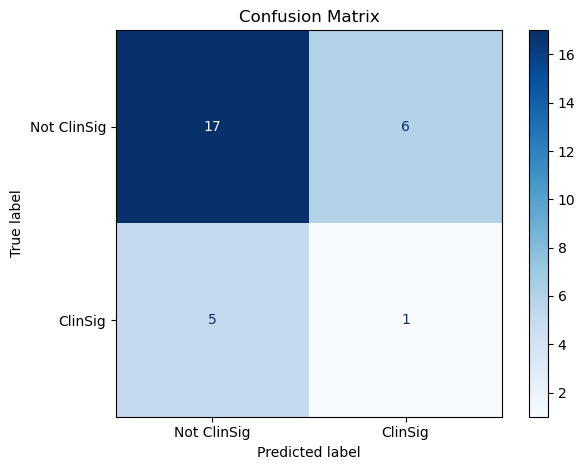

In [2]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# === Config ===
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE = 4
EPOCHS = 30
LR = 1e-4
GAMMA = 3.0
THRESHOLD = 0.5
TARGET_SHAPE = (3, 64, 64, 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Focal Loss ===
def focal_loss(logits, targets, gamma=GAMMA):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt = torch.exp(-bce)
    return ((1 - pt) ** gamma * bce).mean()

# === Augmentation ===
def augment(volume):
    if random.random() < 0.5:
        volume = np.flip(volume, axis=2)  # Horizontal
    if random.random() < 0.5:
        volume = np.flip(volume, axis=3)  # Vertical
    if random.random() < 0.5:
        k = random.choice([1, 2, 3])
        volume = np.rot90(volume, k, axes=(2, 3)).copy()
    return volume

# === Resize + optional augment ===
def resize_volume(vol, target_shape, augment_flag=False):
    if augment_flag:
        vol = augment(vol)
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d, h, w = min(d, td), min(h, th), min(w, tw)
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

# === Data loader with augment for ClinSig ===
def load_tensor_dataset(df, shape=TARGET_SHAPE, augment_clinsig=False):
    x_list, y_list, ids = [], [], []
    for _, row in df.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            is_clinsig = row['ClinSig'] == 1
            vol = resize_volume(vol, shape, augment_flag=augment_clinsig and is_clinsig)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
            ids.append(row['ProxID'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor), ids

# === Data prep ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)
df['ProxID'] = df['ProxID'].apply(lambda x: x if x.startswith("ProstateX-") else f"ProstateX-{x}")
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]

# === Train/val split + duplicate ClinSig once ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)
clinsig_df = train_df[train_df['ClinSig'] == 1]
train_df = pd.concat([train_df, clinsig_df], ignore_index=True)

# === Display counts ===
print("📊 Train class distribution:\n", train_df['ClinSig'].value_counts())
print("📊 Val class distribution:\n", val_df['ClinSig'].value_counts())

# === Load Datasets ===
train_data, _ = load_tensor_dataset(train_df, augment_clinsig=True)
val_data, val_ids = load_tensor_dataset(val_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# === Deep CNN Model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, 3, padding=1), nn.BatchNorm3d(16), nn.LeakyReLU(),
    nn.Conv3d(16, 32, 3, padding=1), nn.BatchNorm3d(32), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(64 * 16 * 16 * 16, 256), nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_batch).squeeze()
        loss = focal_loss(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")
    scheduler.step(total_loss)

# === Evaluation ===
model.eval()
all_preds, all_labels, all_proxids = [], [], []
index = 0

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(int)
        preds = np.atleast_1d(preds)
        y_batch = y_batch.numpy()
        for i in range(len(preds)):
            prox_id = val_ids[index]
            all_proxids.append(prox_id)
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

# === Report ===
print("\n📊 Final Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

print("\n🧠 Sample Predictions:")
for pid, pred, label in zip(all_proxids[:10], all_preds[:10], all_labels[:10]):
    print(f"{pid}: Predicted={pred}, Actual={label}")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


📊 Train class distribution:
 ClinSig
0    94
1    44
Name: count, dtype: int64
📊 Val class distribution:
 ClinSig
0    23
1     6
Name: count, dtype: int64


Epoch 1/30: 100%|██████████| 35/35 [00:03<00:00, 11.52it/s]


Epoch 1 - Loss: 59.5957


Epoch 2/30: 100%|██████████| 35/35 [00:03<00:00, 11.40it/s]


Epoch 2 - Loss: 23.9127


Epoch 3/30: 100%|██████████| 35/35 [00:02<00:00, 11.69it/s]


Epoch 3 - Loss: 29.3511


Epoch 4/30: 100%|██████████| 35/35 [00:03<00:00, 11.64it/s]


Epoch 4 - Loss: 17.2489


Epoch 5/30: 100%|██████████| 35/35 [00:03<00:00, 11.53it/s]


Epoch 5 - Loss: 9.8323


Epoch 6/30: 100%|██████████| 35/35 [00:03<00:00, 11.54it/s]


Epoch 6 - Loss: 3.0905


Epoch 7/30: 100%|██████████| 35/35 [00:03<00:00, 11.42it/s]


Epoch 7 - Loss: 3.7106


Epoch 8/30: 100%|██████████| 35/35 [00:03<00:00, 11.45it/s]


Epoch 8 - Loss: 7.0994


Epoch 9/30: 100%|██████████| 35/35 [00:03<00:00, 11.57it/s]


Epoch 9 - Loss: 2.4752


Epoch 10/30: 100%|██████████| 35/35 [00:03<00:00, 11.36it/s]


Epoch 10 - Loss: 4.7508


Epoch 11/30: 100%|██████████| 35/35 [00:03<00:00, 11.52it/s]


Epoch 11 - Loss: 5.6577


Epoch 12/30: 100%|██████████| 35/35 [00:03<00:00, 11.58it/s]


Epoch 12 - Loss: 1.9095


Epoch 13/30: 100%|██████████| 35/35 [00:03<00:00, 11.40it/s]


Epoch 13 - Loss: 2.6641


Epoch 14/30: 100%|██████████| 35/35 [00:03<00:00, 11.35it/s]


Epoch 14 - Loss: 5.5289


Epoch 15/30: 100%|██████████| 35/35 [00:03<00:00, 11.42it/s]


Epoch 15 - Loss: 6.7989


Epoch 16/30: 100%|██████████| 35/35 [00:03<00:00, 11.46it/s]


Epoch 16 - Loss: 2.2078


Epoch 17/30: 100%|██████████| 35/35 [00:03<00:00, 11.51it/s]


Epoch 17 - Loss: 2.0110


Epoch 18/30: 100%|██████████| 35/35 [00:03<00:00, 11.36it/s]


Epoch 18 - Loss: 1.3117


Epoch 19/30: 100%|██████████| 35/35 [00:03<00:00, 11.43it/s]


Epoch 19 - Loss: 0.7694


Epoch 20/30: 100%|██████████| 35/35 [00:03<00:00, 11.51it/s]


Epoch 20 - Loss: 0.5123


Epoch 21/30: 100%|██████████| 35/35 [00:03<00:00, 11.58it/s]


Epoch 21 - Loss: 0.4750


Epoch 22/30: 100%|██████████| 35/35 [00:03<00:00, 11.46it/s]


Epoch 22 - Loss: 0.4454


Epoch 23/30: 100%|██████████| 35/35 [00:03<00:00, 11.38it/s]


Epoch 23 - Loss: 0.5568


Epoch 24/30: 100%|██████████| 35/35 [00:03<00:00, 11.44it/s]


Epoch 24 - Loss: 0.7683


Epoch 25/30: 100%|██████████| 35/35 [00:03<00:00, 11.42it/s]


Epoch 25 - Loss: 0.4998


Epoch 26/30: 100%|██████████| 35/35 [00:03<00:00, 11.44it/s]


Epoch 26 - Loss: 0.5002


Epoch 27/30: 100%|██████████| 35/35 [00:03<00:00, 11.42it/s]


Epoch 27 - Loss: 1.0041


Epoch 28/30: 100%|██████████| 35/35 [00:03<00:00, 11.40it/s]


Epoch 28 - Loss: 0.4866


Epoch 29/30: 100%|██████████| 35/35 [00:03<00:00, 11.27it/s]


Epoch 29 - Loss: 0.3943


Epoch 30/30: 100%|██████████| 35/35 [00:03<00:00, 11.36it/s]


Epoch 30 - Loss: 0.5450

📊 Final Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.79      0.83      0.81        23
     ClinSig       0.20      0.17      0.18         6

    accuracy                           0.69        29
   macro avg       0.50      0.50      0.50        29
weighted avg       0.67      0.69      0.68        29


🧠 Sample Predictions:
ProstateX-0026: Predicted=1, Actual=1
ProstateX-0045: Predicted=0, Actual=0
ProstateX-0072: Predicted=0, Actual=0
ProstateX-0084: Predicted=0, Actual=0
ProstateX-0022: Predicted=1, Actual=0
ProstateX-0054: Predicted=0, Actual=0
ProstateX-0091: Predicted=1, Actual=0
ProstateX-0100: Predicted=0, Actual=0
ProstateX-0046: Predicted=0, Actual=0
ProstateX-0076: Predicted=0, Actual=0


<Figure size 500x400 with 0 Axes>

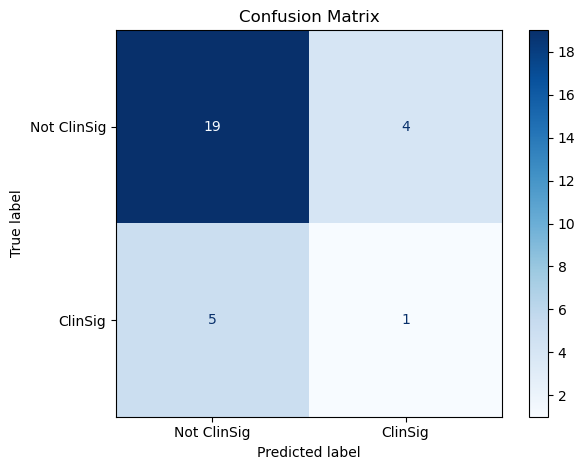

In [37]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# === Config ===
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE = 4
EPOCHS = 30
LR = 1e-4
GAMMA = 3.0
THRESHOLD = 0.5
TARGET_SHAPE = (3, 64, 64, 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Focal Loss ===
def focal_loss(logits, targets, gamma=GAMMA):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt = torch.exp(-bce)
    return ((1 - pt) ** gamma * bce).mean()

# === Augmentation ===
def augment(volume):
    if random.random() < 0.5:
        volume = np.flip(volume, axis=2)  # Horizontal
    if random.random() < 0.5:
        volume = np.flip(volume, axis=3)  # Vertical
    if random.random() < 0.5:
        k = random.choice([1, 2, 3])
        volume = np.rot90(volume, k, axes=(2, 3)).copy()
    return volume

# === Resize + optional augment ===
def resize_volume(vol, target_shape, augment_flag=False):
    if augment_flag:
        vol = augment(vol)
    c, d, h, w = vol.shape
    tc, td, th, tw = target_shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d, h, w = min(d, td), min(h, th), min(w, tw)
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

# === Data loader with augment for ClinSig ===
def load_tensor_dataset(df, shape=TARGET_SHAPE, augment_clinsig=False):
    x_list, y_list, ids = [], [], []
    for _, row in df.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            is_clinsig = row['ClinSig'] == 1
            vol = resize_volume(vol, shape, augment_flag=augment_clinsig and is_clinsig)
            x_list.append(vol)
            y_list.append(row['ClinSig'])
            ids.append(row['ProxID'])
        except Exception as e:
            print(f"[ERROR] Skipping {row['ProxID']}: {e}")
    x_tensor = torch.tensor(np.stack(x_list))
    y_tensor = torch.tensor(y_list, dtype=torch.float32)
    return TensorDataset(x_tensor, y_tensor), ids

# === Data prep ===
df = pd.read_csv(FINDINGS_CSV)
df = df.dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str)
df['ClinSig'] = df['ClinSig'].astype(int)
df['ProxID'] = df['ProxID'].apply(lambda x: x if x.startswith("ProstateX-") else f"ProstateX-{x}")
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]

# === Train/val split + duplicate ClinSig once ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)
clinsig_df = train_df[train_df['ClinSig'] == 1]
train_df = pd.concat([train_df, clinsig_df], ignore_index=True)

# === Display counts ===
print("📊 Train class distribution:\n", train_df['ClinSig'].value_counts())
print("📊 Val class distribution:\n", val_df['ClinSig'].value_counts())

# === Load Datasets ===
train_data, _ = load_tensor_dataset(train_df, augment_clinsig=True)
val_data, val_ids = load_tensor_dataset(val_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# === Deep CNN Model ===
model = nn.Sequential(
    nn.Conv3d(3, 16, 3, padding=1), nn.BatchNorm3d(16), nn.LeakyReLU(),
    nn.Conv3d(16, 32, 3, padding=1), nn.BatchNorm3d(32), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(64 * 16 * 16 * 16, 256), nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 1)
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# === Training Loop ===
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_batch).squeeze()
        loss = focal_loss(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")
    scheduler.step(total_loss)



# === Evaluation ===
model.eval()
all_preds, all_labels, all_proxids = [], [], []
index = 0

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(int)
        preds = np.atleast_1d(preds)
        y_batch = y_batch.numpy()
        for i in range(len(preds)):
            prox_id = val_ids[index]
            all_proxids.append(prox_id)
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

# === Report ===
print("\n📊 Final Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

print("\n🧠 Sample Predictions:")
for pid, pred, label in zip(all_proxids[:10], all_preds[:10], all_labels[:10]):
    print(f"{pid}: Predicted={pred}, Actual={label}")

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



📊 Final Evaluation Report:
              precision    recall  f1-score   support

 Not ClinSig       0.74      0.74      0.74        23
     ClinSig       0.00      0.00      0.00         6

    accuracy                           0.59        29
   macro avg       0.37      0.37      0.37        29
weighted avg       0.59      0.59      0.59        29


🧠 Sample Predictions:
ProstateX-0026: Predicted=0, Actual=1
ProstateX-0045: Predicted=0, Actual=0
ProstateX-0072: Predicted=0, Actual=0
ProstateX-0084: Predicted=0, Actual=0
ProstateX-0022: Predicted=1, Actual=0
ProstateX-0054: Predicted=1, Actual=0
ProstateX-0091: Predicted=1, Actual=0
ProstateX-0100: Predicted=0, Actual=0
ProstateX-0046: Predicted=0, Actual=0
ProstateX-0076: Predicted=0, Actual=0


<Figure size 500x400 with 0 Axes>

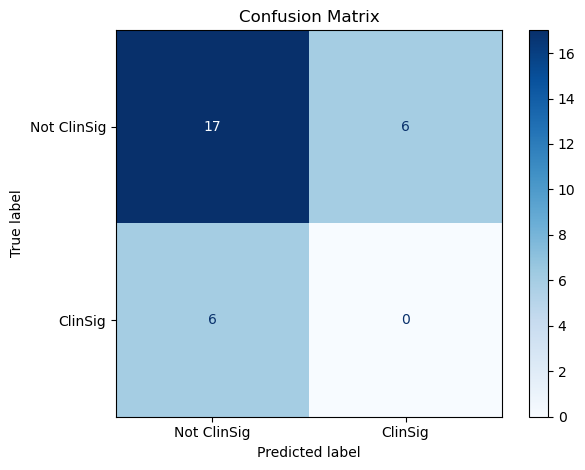


📊 Threshold Sweep:
Threshold 0.30 → Precision: 0.15, Recall: 0.67
Threshold 0.35 → Precision: 0.16, Recall: 0.50
Threshold 0.40 → Precision: 0.23, Recall: 0.50
Threshold 0.45 → Precision: 0.11, Recall: 0.17
Threshold 0.50 → Precision: 0.00, Recall: 0.00
Threshold 0.55 → Precision: 0.00, Recall: 0.00
Threshold 0.60 → Precision: 0.00, Recall: 0.00
Threshold 0.65 → Precision: 0.00, Recall: 0.00
Threshold 0.70 → Precision: 0.00, Recall: 0.00
Threshold 0.75 → Precision: 0.00, Recall: 0.00
Threshold 0.80 → Precision: 0.00, Recall: 0.00


In [9]:

# === Evaluate ===
model.eval()
all_preds, all_labels, all_proxids, all_probs = [], [], [], []
index = 0
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs > THRESHOLD).astype(int)
        all_probs.extend(np.atleast_1d(probs).tolist())
        preds = np.atleast_1d(preds); y_batch = y_batch.numpy()
        for i in range(len(preds)):
            all_proxids.append(val_ids[index])
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

print("\n📊 Final Evaluation Report:")
print(classification_report(all_labels, all_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))
print("\n🧠 Sample Predictions:")
for pid, pred, label in zip(all_proxids[:10], all_preds[:10], all_labels[:10]):
    print(f"{pid}: Predicted={pred}, Actual={label}")

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix"); plt.tight_layout(); plt.show()

# === Threshold Sweep ===
print("\n📊 Threshold Sweep:")
for t in np.arange(0.3, 0.81, 0.05):
    test_preds = (np.array(all_probs) > t).astype(int)
    p = precision_score(all_labels, test_preds, zero_division=0)
    r = recall_score(all_labels, test_preds, zero_division=0)
    print(f"Threshold {t:.2f} → Precision: {p:.2f}, Recall: {r:.2f}")



🔍 Dynamic Threshold Search (Optimising F1 Score):
Thresh   Prec     Rec      F1      
0.10     0.21     1.00     0.34
0.11     0.21     1.00     0.34
0.12     0.21     1.00     0.34
0.13     0.21     1.00     0.34
0.14     0.21     1.00     0.34
0.15     0.21     1.00     0.34
0.16     0.21     1.00     0.34
0.17     0.21     1.00     0.34
0.18     0.21     1.00     0.34
0.19     0.21     1.00     0.34
0.20     0.21     1.00     0.34
0.21     0.21     1.00     0.34
0.22     0.21     1.00     0.34
0.23     0.21     1.00     0.34
0.24     0.21     1.00     0.34
0.25     0.21     1.00     0.34
0.26     0.18     0.83     0.29
0.27     0.18     0.83     0.29
0.28     0.18     0.83     0.29
0.29     0.15     0.67     0.24
0.30     0.15     0.67     0.24
0.31     0.12     0.50     0.19
0.32     0.12     0.50     0.20
0.33     0.14     0.50     0.21
0.34     0.15     0.50     0.23
0.35     0.16     0.50     0.24
0.36     0.16     0.50     0.24
0.37     0.16     0.50     0.24
0.38     0.17    

<Figure size 500x400 with 0 Axes>

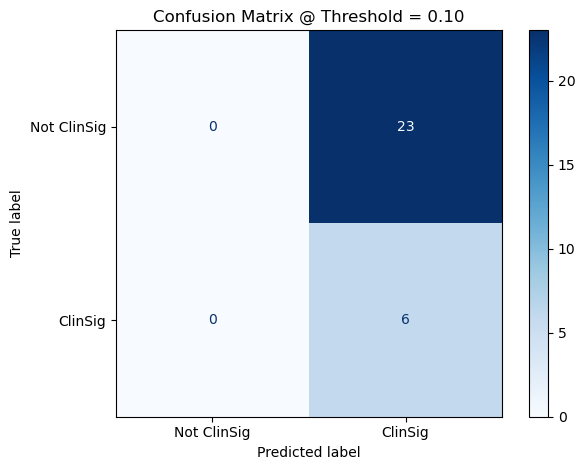

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score

# === Dynamic Threshold Optimisation ===
best_threshold = 0.5
best_f1 = 0.0

print("\n🔍 Dynamic Threshold Search (Optimising F1 Score):")
print(f"{'Thresh':<8} {'Prec':<8} {'Rec':<8} {'F1':<8}")
for t in np.arange(0.1, 0.81, 0.01):
    test_preds = (np.array(all_probs) > t).astype(int)
    prec = precision_score(all_labels, test_preds, zero_division=0)
    rec = recall_score(all_labels, test_preds, zero_division=0)
    f1 = f1_score(all_labels, test_preds, zero_division=0)
    print(f"{t:.2f}     {prec:.2f}     {rec:.2f}     {f1:.2f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\n✅ Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.2f}")

# === Final Report with Best Threshold ===
final_preds = (np.array(all_probs) > best_threshold).astype(int)
print("\n📊 Classification Report at Best Threshold:")
print(classification_report(all_labels, final_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

# === Updated Confusion Matrix ===
cm_best = confusion_matrix(all_labels, final_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix @ Threshold = {best_threshold:.2f}")
plt.tight_layout()
plt.show()


📊 Train class distribution:
 ClinSig
0    94
1    44
Name: count, dtype: int64
📊 Val class distribution:
 ClinSig
0    23
1     6
Name: count, dtype: int64


Epoch 1/30: 100%|██████████| 35/35 [00:02<00:00, 14.49it/s]


Epoch 1 - Loss: 3.0881


Epoch 2/30: 100%|██████████| 35/35 [00:02<00:00, 14.38it/s]


Epoch 2 - Loss: 2.5116


Epoch 3/30: 100%|██████████| 35/35 [00:02<00:00, 14.30it/s]


Epoch 3 - Loss: 2.4834


Epoch 4/30: 100%|██████████| 35/35 [00:02<00:00, 14.48it/s]


Epoch 4 - Loss: 2.3563


Epoch 5/30: 100%|██████████| 35/35 [00:02<00:00, 14.46it/s]


Epoch 5 - Loss: 2.2605


Epoch 6/30: 100%|██████████| 35/35 [00:02<00:00, 14.53it/s]


Epoch 6 - Loss: 2.0482


Epoch 7/30: 100%|██████████| 35/35 [00:02<00:00, 14.59it/s]


Epoch 7 - Loss: 1.9578


Epoch 8/30: 100%|██████████| 35/35 [00:02<00:00, 14.46it/s]


Epoch 8 - Loss: 2.0088


Epoch 9/30: 100%|██████████| 35/35 [00:02<00:00, 14.18it/s]


Epoch 9 - Loss: 1.9087


Epoch 10/30: 100%|██████████| 35/35 [00:02<00:00, 14.45it/s]


Epoch 10 - Loss: 1.8686


Epoch 11/30: 100%|██████████| 35/35 [00:02<00:00, 14.04it/s]


Epoch 11 - Loss: 2.1207


Epoch 12/30: 100%|██████████| 35/35 [00:02<00:00, 14.10it/s]


Epoch 12 - Loss: 1.8288


Epoch 13/30: 100%|██████████| 35/35 [00:02<00:00, 14.25it/s]


Epoch 13 - Loss: 1.9432


Epoch 14/30: 100%|██████████| 35/35 [00:02<00:00, 14.33it/s]


Epoch 14 - Loss: 1.6961


Epoch 15/30: 100%|██████████| 35/35 [00:02<00:00, 14.21it/s]


Epoch 15 - Loss: 1.6682


Epoch 16/30: 100%|██████████| 35/35 [00:02<00:00, 14.20it/s]


Epoch 16 - Loss: 1.4630


Epoch 17/30: 100%|██████████| 35/35 [00:02<00:00, 14.46it/s]


Epoch 17 - Loss: 1.3897


Epoch 18/30: 100%|██████████| 35/35 [00:02<00:00, 14.36it/s]


Epoch 18 - Loss: 1.8812


Epoch 19/30: 100%|██████████| 35/35 [00:02<00:00, 14.43it/s]


Epoch 19 - Loss: 1.5777


Epoch 20/30: 100%|██████████| 35/35 [00:02<00:00, 14.44it/s]


Epoch 20 - Loss: 1.3841


Epoch 21/30: 100%|██████████| 35/35 [00:02<00:00, 14.35it/s]


Epoch 21 - Loss: 1.3520


Epoch 22/30: 100%|██████████| 35/35 [00:02<00:00, 13.98it/s]


Epoch 22 - Loss: 1.3287


Epoch 23/30: 100%|██████████| 35/35 [00:02<00:00, 14.18it/s]


Epoch 23 - Loss: 1.4042


Epoch 24/30: 100%|██████████| 35/35 [00:02<00:00, 14.26it/s]


Epoch 24 - Loss: 1.4086


Epoch 25/30: 100%|██████████| 35/35 [00:02<00:00, 14.28it/s]


Epoch 25 - Loss: 1.3395


Epoch 26/30: 100%|██████████| 35/35 [00:02<00:00, 14.27it/s]


Epoch 26 - Loss: 1.1168


Epoch 27/30: 100%|██████████| 35/35 [00:02<00:00, 14.26it/s]


Epoch 27 - Loss: 1.4877


Epoch 28/30: 100%|██████████| 35/35 [00:02<00:00, 14.16it/s]


Epoch 28 - Loss: 1.1875


Epoch 29/30: 100%|██████████| 35/35 [00:02<00:00, 14.21it/s]


Epoch 29 - Loss: 1.0074


Epoch 30/30: 100%|██████████| 35/35 [00:02<00:00, 14.24it/s]


Epoch 30 - Loss: 1.2360

🔍 Dynamic Threshold Search (Optimising F1 Score):
Thresh   Prec     Rec      F1      
0.10     0.21     1.00     0.34
0.11     0.21     1.00     0.34
0.12     0.21     1.00     0.34
0.13     0.21     1.00     0.35
0.14     0.19     0.83     0.30
0.15     0.19     0.83     0.30
0.16     0.19     0.83     0.30
0.17     0.19     0.83     0.30
0.18     0.19     0.83     0.30
0.19     0.16     0.67     0.26
0.20     0.16     0.67     0.26
0.21     0.12     0.50     0.20
0.22     0.13     0.50     0.21
0.23     0.13     0.50     0.21
0.24     0.13     0.50     0.21
0.25     0.13     0.50     0.21
0.26     0.13     0.50     0.21
0.27     0.14     0.50     0.21
0.28     0.14     0.50     0.21
0.29     0.15     0.50     0.23
0.30     0.15     0.50     0.23
0.31     0.11     0.33     0.16
0.32     0.11     0.33     0.17
0.33     0.11     0.33     0.17
0.34     0.12     0.33     0.17
0.35     0.12     0.33     0.17
0.36     0.13     0.33     0.19
0.37     0.14     0.33   

<Figure size 500x400 with 0 Axes>

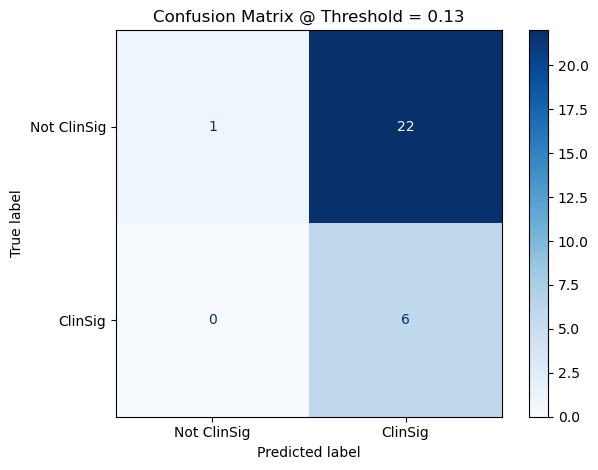

In [13]:
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from tqdm import tqdm

# === Config ===
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE, EPOCHS, LR = 4, 30, 1e-4
THRESHOLD = 0.5  # used for final evaluation, will be tuned dynamically
GAMMA = 3.0
TARGET_SHAPE = (3, 64, 64, 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Focal loss ===
def focal_loss(logits, targets, gamma=GAMMA):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt = torch.exp(-bce)
    return ((1 - pt) ** gamma * bce).mean()

# === Augmentation (reduced) ===
def augment(volume):
    if random.random() < 0.5: volume = np.flip(volume, axis=2)
    if random.random() < 0.5: volume = np.flip(volume, axis=3)
    return volume

# === Resize + augment
def resize_volume(vol, target_shape, augment_flag=False):
    if augment_flag: vol = augment(vol)
    c, d, h, w = vol.shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d, h, w = min(d, target_shape[1]), min(h, target_shape[2]), min(w, target_shape[3])
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

# === Dataset loader
def load_tensor_dataset(df, shape=TARGET_SHAPE, augment_clinsig=False):
    x_list, y_list, ids = [], [], []
    for _, row in df.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            vol = resize_volume(vol, shape, augment_flag=(augment_clinsig and row['ClinSig'] == 1))
            x_list.append(vol); y_list.append(row['ClinSig']); ids.append(row['ProxID'])
        except Exception as e:
            print(f"[ERROR] {row['ProxID']}: {e}")
    return TensorDataset(torch.tensor(np.stack(x_list)), torch.tensor(y_list, dtype=torch.float32)), ids

# === Load CSV
df = pd.read_csv(FINDINGS_CSV).dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str).apply(lambda x: f"ProstateX-{x}" if not x.startswith("ProstateX-") else x)
df['ClinSig'] = df['ClinSig'].astype(int)
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]

# === Split + oversample ClinSig once
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)
train_df = pd.concat([train_df, train_df[train_df['ClinSig'] == 1]], ignore_index=True)

print("📊 Train class distribution:\n", train_df['ClinSig'].value_counts())
print("📊 Val class distribution:\n", val_df['ClinSig'].value_counts())

train_data, _ = load_tensor_dataset(train_df, augment_clinsig=True)
val_data, val_ids = load_tensor_dataset(val_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# === Deep CNN with GAP
model = nn.Sequential(
    nn.Conv3d(3, 16, 3, padding=1), nn.BatchNorm3d(16), nn.LeakyReLU(),
    nn.Conv3d(16, 32, 3, padding=1), nn.BatchNorm3d(32), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.LeakyReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(64, 128, 3, padding=1), nn.BatchNorm3d(128), nn.LeakyReLU(),
    nn.AdaptiveAvgPool3d(1),
    nn.Flatten(),
    nn.Dropout(0.2),
    nn.Linear(128, 1)
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# === Train
for epoch in range(EPOCHS):
    model.train(); total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_batch).squeeze()
        # === Label smoothing
        y_smoothed = y_batch * 0.9 + 0.05
        loss = focal_loss(logits, y_smoothed)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")
    scheduler.step(total_loss)

# === Evaluate
model.eval()
all_preds, all_labels, all_probs, all_proxids = [], [], [], []
index = 0
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        probs = np.atleast_1d(probs)
        preds = (probs > THRESHOLD).astype(int)
        all_probs.extend(probs.tolist())
        y_batch = y_batch.numpy()
        for i in range(len(preds)):
            all_proxids.append(val_ids[index])
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

# === F1 Threshold Sweep
best_threshold, best_f1 = 0.5, 0.0
print("\n🔍 Dynamic Threshold Search (Optimising F1 Score):")
print(f"{'Thresh':<8} {'Prec':<8} {'Rec':<8} {'F1':<8}")
for t in np.arange(0.1, 0.81, 0.01):
    test_preds = (np.array(all_probs) > t).astype(int)
    p = precision_score(all_labels, test_preds, zero_division=0)
    r = recall_score(all_labels, test_preds, zero_division=0)
    f1 = f1_score(all_labels, test_preds, zero_division=0)
    print(f"{t:.2f}     {p:.2f}     {r:.2f}     {f1:.2f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# === Final eval at best threshold
print(f"\n✅ Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.2f}")
final_preds = (np.array(all_probs) > best_threshold).astype(int)
print("\n📊 Classification Report at Best Threshold:")
print(classification_report(all_labels, final_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

# === Confusion Matrix
cm = confusion_matrix(all_labels, final_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix @ Threshold = {best_threshold:.2f}")
plt.tight_layout()
plt.show()


📊 Train class distribution:
 ClinSig
0    94
1    44
Name: count, dtype: int64
📊 Val class distribution:
 ClinSig
0    23
1     6
Name: count, dtype: int64


Epoch 1/30: 100%|██████████| 35/35 [00:03<00:00,  9.67it/s]


Epoch 1 - Loss: 41.6973


Epoch 2/30: 100%|██████████| 35/35 [00:03<00:00,  9.87it/s]


Epoch 2 - Loss: 14.8099


Epoch 3/30: 100%|██████████| 35/35 [00:03<00:00,  9.64it/s]


Epoch 3 - Loss: 7.2774


Epoch 4/30: 100%|██████████| 35/35 [00:03<00:00,  9.68it/s]


Epoch 4 - Loss: 3.6672


Epoch 5/30: 100%|██████████| 35/35 [00:03<00:00,  9.72it/s]


Epoch 5 - Loss: 3.6199


Epoch 6/30: 100%|██████████| 35/35 [00:03<00:00,  9.64it/s]


Epoch 6 - Loss: 2.5151


Epoch 7/30: 100%|██████████| 35/35 [00:03<00:00,  9.61it/s]


Epoch 7 - Loss: 2.1291


Epoch 8/30: 100%|██████████| 35/35 [00:03<00:00,  9.50it/s]


Epoch 8 - Loss: 2.1664


Epoch 9/30: 100%|██████████| 35/35 [00:03<00:00,  9.55it/s]


Epoch 9 - Loss: 2.1275


Epoch 10/30: 100%|██████████| 35/35 [00:03<00:00,  9.62it/s]


Epoch 10 - Loss: 1.8126


Epoch 11/30: 100%|██████████| 35/35 [00:03<00:00,  9.61it/s]


Epoch 11 - Loss: 1.5319


Epoch 12/30: 100%|██████████| 35/35 [00:03<00:00,  9.47it/s]


Epoch 12 - Loss: 1.7263


Epoch 13/30: 100%|██████████| 35/35 [00:03<00:00,  9.64it/s]


Epoch 13 - Loss: 1.5791


Epoch 14/30: 100%|██████████| 35/35 [00:03<00:00,  9.66it/s]


Epoch 14 - Loss: 1.4352


Epoch 15/30: 100%|██████████| 35/35 [00:03<00:00,  9.63it/s]


Epoch 15 - Loss: 1.1258


Epoch 16/30: 100%|██████████| 35/35 [00:03<00:00,  9.55it/s]


Epoch 16 - Loss: 2.0412


Epoch 17/30: 100%|██████████| 35/35 [00:03<00:00,  9.55it/s]


Epoch 17 - Loss: 1.4861


Epoch 18/30: 100%|██████████| 35/35 [00:03<00:00,  9.54it/s]


Epoch 18 - Loss: 1.1625


Epoch 19/30: 100%|██████████| 35/35 [00:03<00:00,  9.56it/s]


Epoch 19 - Loss: 1.6974


Epoch 20/30: 100%|██████████| 35/35 [00:03<00:00,  9.56it/s]


Epoch 20 - Loss: 1.0560


Epoch 21/30: 100%|██████████| 35/35 [00:03<00:00,  9.49it/s]


Epoch 21 - Loss: 1.0486


Epoch 22/30: 100%|██████████| 35/35 [00:03<00:00,  9.55it/s]


Epoch 22 - Loss: 1.1949


Epoch 23/30: 100%|██████████| 35/35 [00:03<00:00,  9.63it/s]


Epoch 23 - Loss: 1.0107


Epoch 24/30: 100%|██████████| 35/35 [00:03<00:00,  9.55it/s]


Epoch 24 - Loss: 0.9951


Epoch 25/30: 100%|██████████| 35/35 [00:03<00:00,  9.43it/s]


Epoch 25 - Loss: 1.0178


Epoch 26/30: 100%|██████████| 35/35 [00:03<00:00,  9.49it/s]


Epoch 26 - Loss: 0.8443


Epoch 27/30: 100%|██████████| 35/35 [00:03<00:00,  9.63it/s]


Epoch 27 - Loss: 0.8376


Epoch 28/30: 100%|██████████| 35/35 [00:03<00:00,  9.54it/s]


Epoch 28 - Loss: 0.7459


Epoch 29/30: 100%|██████████| 35/35 [00:03<00:00,  9.56it/s]


Epoch 29 - Loss: 0.7499


Epoch 30/30: 100%|██████████| 35/35 [00:03<00:00,  9.48it/s]


Epoch 30 - Loss: 0.7078

🔍 Dynamic Threshold Search (Optimising F1 Score):
Thresh   Prec     Rec      F1      
0.10     0.21     1.00     0.35
0.11     0.21     1.00     0.35
0.12     0.19     0.83     0.30
0.13     0.19     0.83     0.30
0.14     0.19     0.83     0.30
0.15     0.19     0.83     0.30
0.16     0.19     0.83     0.31
0.17     0.17     0.67     0.27
0.18     0.17     0.67     0.28
0.19     0.17     0.67     0.28
0.20     0.18     0.67     0.29
0.21     0.18     0.67     0.29
0.22     0.18     0.67     0.29
0.23     0.18     0.67     0.29
0.24     0.18     0.67     0.29
0.25     0.11     0.33     0.17
0.26     0.11     0.33     0.17
0.27     0.07     0.17     0.10
0.28     0.07     0.17     0.10
0.29     0.00     0.00     0.00
0.30     0.00     0.00     0.00
0.31     0.00     0.00     0.00
0.32     0.00     0.00     0.00
0.33     0.00     0.00     0.00
0.34     0.00     0.00     0.00
0.35     0.00     0.00     0.00
0.36     0.00     0.00     0.00
0.37     0.00     0.00   

<Figure size 500x400 with 0 Axes>

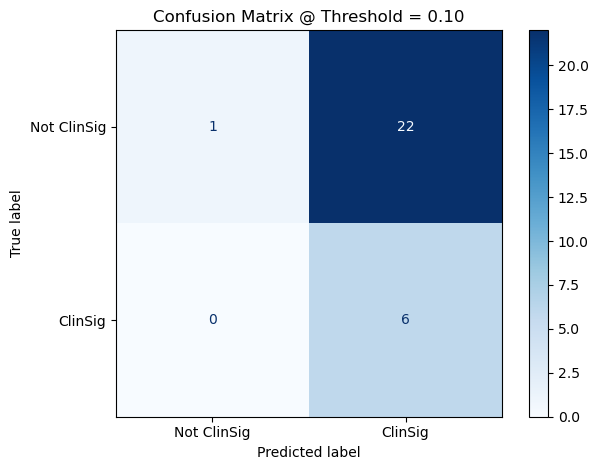

In [15]:
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from tqdm import tqdm

# === Config
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE, EPOCHS, LR = 4, 30, 1e-4
GAMMA = 3.0
TARGET_SHAPE = (3, 64, 64, 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Loss
def focal_loss(logits, targets, gamma=GAMMA):
    bce = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    pt = torch.exp(-bce)
    return ((1 - pt) ** gamma * bce).mean()

# === Aug + resize
def augment(volume):
    if random.random() < 0.5: volume = np.flip(volume, axis=2)
    if random.random() < 0.5: volume = np.flip(volume, axis=3)
    return volume

def resize_volume(vol, target_shape, augment_flag=False):
    if augment_flag: vol = augment(vol)
    c, d, h, w = vol.shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d, h, w = min(d, target_shape[1]), min(h, target_shape[2]), min(w, target_shape[3])
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

# === Dataset loader
def load_tensor_dataset(df, shape=TARGET_SHAPE, augment_clinsig=False):
    x_list, y_list, ids = [], [], []
    for _, row in df.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            vol = resize_volume(vol, shape, augment_flag=(augment_clinsig and row['ClinSig'] == 1))
            x_list.append(vol); y_list.append(row['ClinSig']); ids.append(row['ProxID'])
        except Exception as e:
            print(f"[ERROR] {row['ProxID']}: {e}")
    return TensorDataset(torch.tensor(np.stack(x_list)), torch.tensor(y_list, dtype=torch.float32)), ids

# === CSV load + prep
df = pd.read_csv(FINDINGS_CSV).dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str).apply(lambda x: f"ProstateX-{x}" if not x.startswith("ProstateX-") else x)
df['ClinSig'] = df['ClinSig'].astype(int)
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]

# === Train/Val split + light oversampling
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)
train_df = pd.concat([train_df, train_df[train_df['ClinSig'] == 1]], ignore_index=True)

print("📊 Train class distribution:\n", train_df['ClinSig'].value_counts())
print("📊 Val class distribution:\n", val_df['ClinSig'].value_counts())

train_data, _ = load_tensor_dataset(train_df, augment_clinsig=True)
val_data, val_ids = load_tensor_dataset(val_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# === CNN model without classes
model = nn.Sequential(
    # Block 1
    nn.Conv3d(3, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(),
    nn.Conv3d(32, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(),
    nn.MaxPool3d(2),
    # Block 2
    nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(),
    nn.Conv3d(64, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(),
    nn.MaxPool3d(2),
    # Classifier
    nn.Flatten(),
    nn.Dropout(0.3),
    nn.Linear(64 * 16 * 16 * 16, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1)
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# === Train
for epoch in range(EPOCHS):
    model.train(); total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_batch).squeeze()
        loss = focal_loss(logits, y_batch)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")
    scheduler.step(total_loss)

# === Evaluate
model.eval()
all_preds, all_labels, all_probs, all_proxids = [], [], [], []
index = 0
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        logits = model(x_batch).squeeze()
        probs = torch.sigmoid(logits).cpu().numpy()
        probs = np.atleast_1d(probs)
        preds = (probs > 0.5).astype(int)
        all_probs.extend(probs.tolist())
        y_batch = y_batch.numpy()
        for i in range(len(preds)):
            all_proxids.append(val_ids[index])
            all_preds.append(int(preds[i]))
            all_labels.append(int(y_batch[i]))
            index += 1

# === Threshold sweep
best_threshold, best_f1 = 0.5, 0.0
print("\n🔍 Dynamic Threshold Search (Optimising F1 Score):")
print(f"{'Thresh':<8} {'Prec':<8} {'Rec':<8} {'F1':<8}")
for t in np.arange(0.1, 0.81, 0.01):
    test_preds = (np.array(all_probs) > t).astype(int)
    p = precision_score(all_labels, test_preds, zero_division=0)
    r = recall_score(all_labels, test_preds, zero_division=0)
    f1 = f1_score(all_labels, test_preds, zero_division=0)
    print(f"{t:.2f}     {p:.2f}     {r:.2f}     {f1:.2f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# === Final evaluation at best threshold
final_preds = (np.array(all_probs) > best_threshold).astype(int)
print(f"\n✅ Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.2f}")
print("\n📊 Classification Report at Best Threshold:")
print(classification_report(all_labels, final_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

# === Confusion matrix
cm = confusion_matrix(all_labels, final_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix @ Threshold = {best_threshold:.2f}")
plt.tight_layout()
plt.show()


📊 Train class distribution:
 ClinSig
0    94
1    44
Name: count, dtype: int64
📊 Val class distribution:
 ClinSig
0    23
1     6
Name: count, dtype: int64


Epoch 1/30: 100%|██████████| 35/35 [00:03<00:00, 10.13it/s]


Epoch 1 - Loss: 33.5410


Epoch 2/30: 100%|██████████| 35/35 [00:03<00:00, 10.41it/s]


Epoch 2 - Loss: 31.6452


Epoch 3/30: 100%|██████████| 35/35 [00:03<00:00, 10.53it/s]


Epoch 3 - Loss: 27.8615


Epoch 4/30: 100%|██████████| 35/35 [00:03<00:00, 10.46it/s]


Epoch 4 - Loss: 27.5605


Epoch 5/30: 100%|██████████| 35/35 [00:03<00:00, 10.49it/s]


Epoch 5 - Loss: 23.5263


Epoch 6/30: 100%|██████████| 35/35 [00:03<00:00, 10.21it/s]


Epoch 6 - Loss: 24.1143


Epoch 7/30: 100%|██████████| 35/35 [00:03<00:00, 10.37it/s]


Epoch 7 - Loss: 22.5566


Epoch 8/30: 100%|██████████| 35/35 [00:03<00:00, 10.35it/s]


Epoch 8 - Loss: 23.3283


Epoch 9/30: 100%|██████████| 35/35 [00:03<00:00, 10.36it/s]


Epoch 9 - Loss: 18.9912


Epoch 10/30: 100%|██████████| 35/35 [00:03<00:00, 10.33it/s]


Epoch 10 - Loss: 22.2208


Epoch 11/30: 100%|██████████| 35/35 [00:03<00:00, 10.01it/s]


Epoch 11 - Loss: 19.0852


Epoch 12/30: 100%|██████████| 35/35 [00:03<00:00, 10.28it/s]


Epoch 12 - Loss: 18.8988


Epoch 13/30: 100%|██████████| 35/35 [00:03<00:00, 10.40it/s]


Epoch 13 - Loss: 15.2968


Epoch 14/30: 100%|██████████| 35/35 [00:03<00:00, 10.30it/s]


Epoch 14 - Loss: 16.5917


Epoch 15/30: 100%|██████████| 35/35 [00:03<00:00, 10.18it/s]


Epoch 15 - Loss: 15.8907


Epoch 16/30: 100%|██████████| 35/35 [00:03<00:00,  9.92it/s]


Epoch 16 - Loss: 15.1666


Epoch 17/30: 100%|██████████| 35/35 [00:03<00:00, 10.15it/s]


Epoch 17 - Loss: 13.5985


Epoch 18/30: 100%|██████████| 35/35 [00:03<00:00, 10.24it/s]


Epoch 18 - Loss: 17.1192


Epoch 19/30: 100%|██████████| 35/35 [00:03<00:00, 10.29it/s]


Epoch 19 - Loss: 15.9554


Epoch 20/30: 100%|██████████| 35/35 [00:03<00:00, 10.06it/s]


Epoch 20 - Loss: 13.8287


Epoch 21/30: 100%|██████████| 35/35 [00:03<00:00, 10.22it/s]


Epoch 21 - Loss: 12.0442


Epoch 22/30: 100%|██████████| 35/35 [00:03<00:00, 10.21it/s]


Epoch 22 - Loss: 11.5523


Epoch 23/30: 100%|██████████| 35/35 [00:03<00:00, 10.16it/s]


Epoch 23 - Loss: 10.4349


Epoch 24/30: 100%|██████████| 35/35 [00:03<00:00, 10.20it/s]


Epoch 24 - Loss: 10.7998


Epoch 25/30: 100%|██████████| 35/35 [00:03<00:00, 10.09it/s]


Epoch 25 - Loss: 9.7036


Epoch 26/30: 100%|██████████| 35/35 [00:03<00:00, 10.23it/s]


Epoch 26 - Loss: 9.1320


Epoch 27/30: 100%|██████████| 35/35 [00:03<00:00, 10.24it/s]


Epoch 27 - Loss: 9.6995


Epoch 28/30: 100%|██████████| 35/35 [00:03<00:00, 10.22it/s]


Epoch 28 - Loss: 8.9058


Epoch 29/30: 100%|██████████| 35/35 [00:03<00:00, 10.23it/s]


Epoch 29 - Loss: 8.5253


Epoch 30/30: 100%|██████████| 35/35 [00:03<00:00, 10.23it/s]


Epoch 30 - Loss: 8.2696

🔍 Dynamic Threshold Search (Optimising F1 Score):
Thresh   Prec     Rec      F1      
0.10     0.11     0.33     0.16
0.11     0.11     0.33     0.16
0.12     0.11     0.33     0.16
0.13     0.11     0.33     0.17
0.14     0.12     0.33     0.17
0.15     0.12     0.33     0.17
0.16     0.12     0.33     0.17
0.17     0.12     0.33     0.17
0.18     0.12     0.33     0.17
0.19     0.06     0.17     0.09
0.20     0.06     0.17     0.09
0.21     0.06     0.17     0.09
0.22     0.07     0.17     0.10
0.23     0.07     0.17     0.10
0.24     0.07     0.17     0.10
0.25     0.07     0.17     0.10
0.26     0.07     0.17     0.10
0.27     0.07     0.17     0.10
0.28     0.07     0.17     0.10
0.29     0.07     0.17     0.10
0.30     0.08     0.17     0.11
0.31     0.08     0.17     0.11
0.32     0.08     0.17     0.11
0.33     0.08     0.17     0.11
0.34     0.08     0.17     0.11
0.35     0.08     0.17     0.11
0.36     0.08     0.17     0.11
0.37     0.08     0.17   

<Figure size 500x400 with 0 Axes>

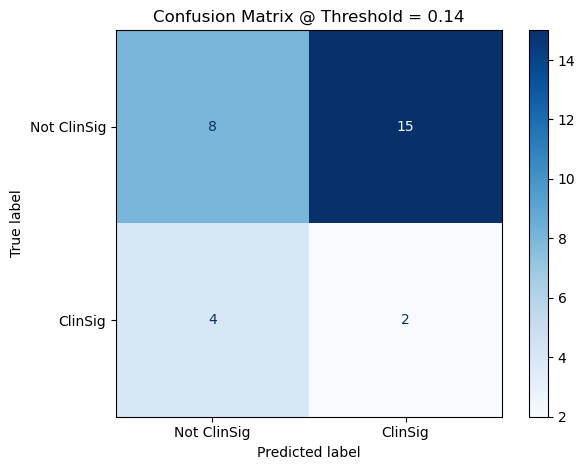

In [17]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, random
import torch, torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from tqdm import tqdm

# === Config
DATA_DIR = r"C:\Users\anude\Downloads\processed_data"
FINDINGS_CSV = r"C:\Users\anude\Downloads\project\ProstateX-Findings-Train100.csv"
BATCH_SIZE, EPOCHS, LR = 4, 30, 1e-4
TARGET_SHAPE = (3, 64, 64, 64)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
POS_WEIGHT = torch.tensor([2.14], device=DEVICE)

# === Resize + Augment
def augment(volume):
    if random.random() < 0.5: volume = np.flip(volume, axis=2)
    if random.random() < 0.5: volume = np.flip(volume, axis=3)
    return volume

def resize_volume(vol, target_shape, augment_flag=False):
    if augment_flag: vol = augment(vol)
    c, d, h, w = vol.shape
    padded = np.zeros(target_shape, dtype=np.float32)
    d, h, w = min(d, target_shape[1]), min(h, target_shape[2]), min(w, target_shape[3])
    padded[:c, :d, :h, :w] = vol[:c, :d, :h, :w]
    return padded

# === Dataset loader
def load_tensor_dataset(df, shape=TARGET_SHAPE, augment_clinsig=False):
    x_list, y_list, ids = [], [], []
    for _, row in df.iterrows():
        try:
            vol = np.load(os.path.join(DATA_DIR, f"{row['ProxID']}.npy")).astype(np.float32)
            vol = resize_volume(vol, shape, augment_flag=(augment_clinsig and row['ClinSig'] == 1))
            x_list.append(vol); y_list.append(row['ClinSig']); ids.append(row['ProxID'])
        except: pass
    return TensorDataset(torch.tensor(np.stack(x_list)), torch.tensor(y_list, dtype=torch.float32)), ids

# === Load CSV
df = pd.read_csv(FINDINGS_CSV).dropna(subset=['ClinSig'])
df['ProxID'] = df['ProxID'].astype(str).apply(lambda x: f"ProstateX-{x}" if not x.startswith("ProstateX-") else x)
df['ClinSig'] = df['ClinSig'].astype(int)
available_ids = {f.replace(".npy", "") for f in os.listdir(DATA_DIR)}
df = df[df['ProxID'].isin(available_ids)]

# === Split + light oversample
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['ClinSig'], random_state=42)
train_df = pd.concat([train_df, train_df[train_df['ClinSig'] == 1]], ignore_index=True)

print("📊 Train class distribution:\n", train_df['ClinSig'].value_counts())
print("📊 Val class distribution:\n", val_df['ClinSig'].value_counts())

train_data, _ = load_tensor_dataset(train_df, augment_clinsig=True)
val_data, val_ids = load_tensor_dataset(val_df)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# === CNN Model (deeper without class)
model = nn.Sequential(
    nn.Conv3d(3, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(),
    nn.Conv3d(32, 32, 3, padding=1), nn.BatchNorm3d(32), nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(32, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(),
    nn.Conv3d(64, 64, 3, padding=1), nn.BatchNorm3d(64), nn.ReLU(),
    nn.MaxPool3d(2),
    nn.Conv3d(64, 128, 3, padding=1), nn.BatchNorm3d(128), nn.ReLU(),
    nn.AdaptiveAvgPool3d((4, 4, 4)),
    nn.Flatten(),
    nn.Dropout(0.3),
    nn.Linear(128 * 4 * 4 * 4, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1)
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=POS_WEIGHT)

# === Train
for epoch in range(EPOCHS):
    model.train(); total_loss = 0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        logits = model(x_batch).squeeze()
        loss = loss_fn(logits, y_batch)
        loss.backward(); optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f}")
    scheduler.step(total_loss)

# === Evaluate
model.eval(); all_preds, all_labels, all_probs, all_proxids = [], [], [], []
index = 0
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(DEVICE)
        probs = torch.sigmoid(model(x_batch).squeeze()).cpu().numpy()
        probs = np.atleast_1d(probs); y_batch = y_batch.numpy()
        all_probs.extend(probs.tolist())
        for i in range(len(probs)):
            all_proxids.append(val_ids[index])
            all_labels.append(int(y_batch[i]))
            index += 1

# === Threshold search
best_threshold, best_f1 = 0.5, 0.0
print("\n🔍 Dynamic Threshold Search (Optimising F1 Score):")
print(f"{'Thresh':<8} {'Prec':<8} {'Rec':<8} {'F1':<8}")
for t in np.arange(0.1, 0.81, 0.01):
    test_preds = (np.array(all_probs) > t).astype(int)
    p = precision_score(all_labels, test_preds, zero_division=0)
    r = recall_score(all_labels, test_preds, zero_division=0)
    f1 = f1_score(all_labels, test_preds, zero_division=0)
    print(f"{t:.2f}     {p:.2f}     {r:.2f}     {f1:.2f}")
    if f1 > best_f1:
        best_f1 = f1; best_threshold = t

# === Final report
final_preds = (np.array(all_probs) > best_threshold).astype(int)
print(f"\n✅ Best Threshold: {best_threshold:.2f} with F1 Score: {best_f1:.2f}")
print("\n📊 Classification Report at Best Threshold:")
print(classification_report(all_labels, final_preds, target_names=["Not ClinSig", "ClinSig"], zero_division=0))

# === Confusion Matrix
cm = confusion_matrix(all_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not ClinSig", "ClinSig"])
plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f"Confusion Matrix @ Threshold = {best_threshold:.2f}")
plt.tight_layout()
plt.show()
